In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df_data = pd.read_csv('./data/widget_sales.csv')
df_data.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [7]:
df_data.shape

(500, 1)

In [12]:
df_data.index = pd.date_range(start='2019-01-01', periods=500, freq='D')

<Axes: >

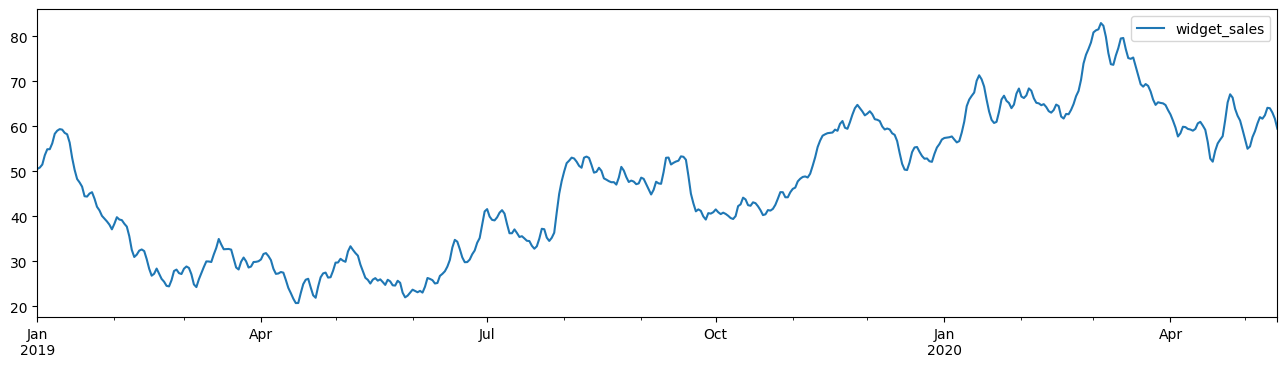

In [13]:
df_data.plot(figsize=(16,4))

In [20]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


In [15]:


ADF_result = adfuller(df_data.widget_sales)
ADF_result

(-1.5121662069359003,
 0.5274845352272627,
 3,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1354.8017397952053)

In [17]:
widget_sales_diff = np.diff(df_data.widget_sales, n=1)

In [24]:
df_diff = pd.DataFrame(widget_sales_diff)
df_diff.index = pd.date_range(start='2019-01-02', periods=499, freq='D')
df_diff

,0
2019-01-02,0.308778
2019-01-03,0.672265
2019-01-04,2.064470
2019-01-05,1.330880
2019-01-06,0.012034
...,...
2020-05-10,1.651336
2020-05-11,-0.095290
2020-05-12,-0.962187
2020-05-13,-1.358097


<Axes: >

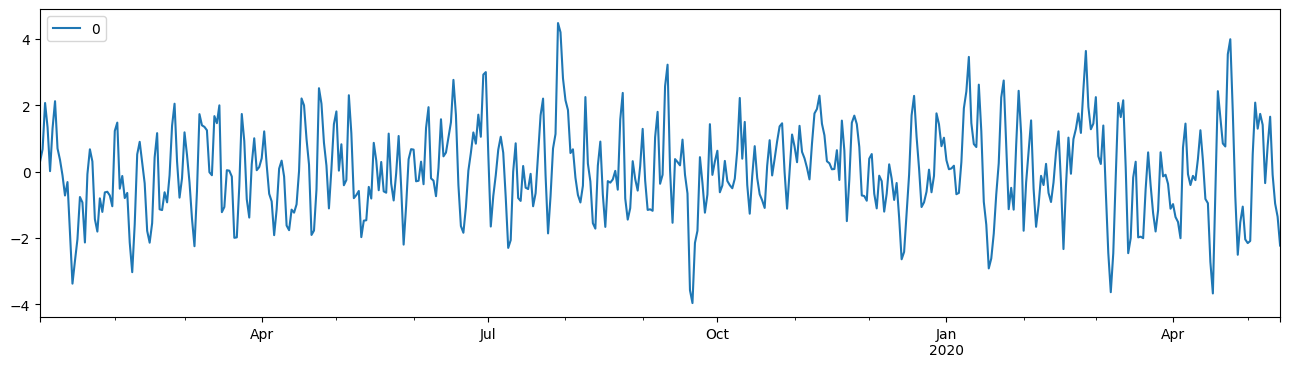

In [25]:
df_diff.plot(figsize=(16,4))

In [19]:
ADF_result = adfuller(widget_sales_diff)
ADF_result

(-10.576657780341957,
 7.076922818587346e-19,
 2,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1350.640860630276)

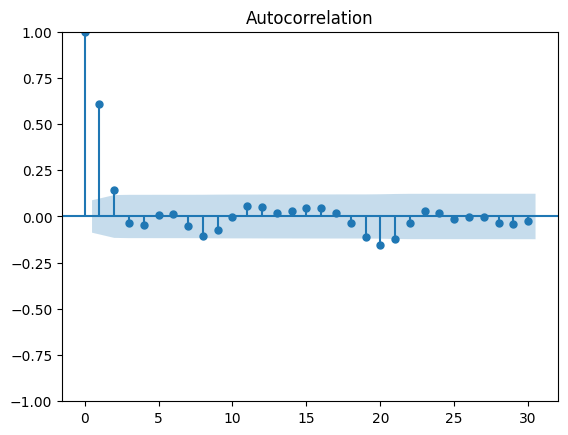

In [22]:
plot_acf(widget_sales_diff, lags=30)
plt.show()

In [47]:
pd.date_range(end='2020-05-14', periods=50, freq='D')

DatetimeIndex(['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
               '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
               '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
               '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
               '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
               '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14'],
              dtype='datetime64[ns]', freq='D')

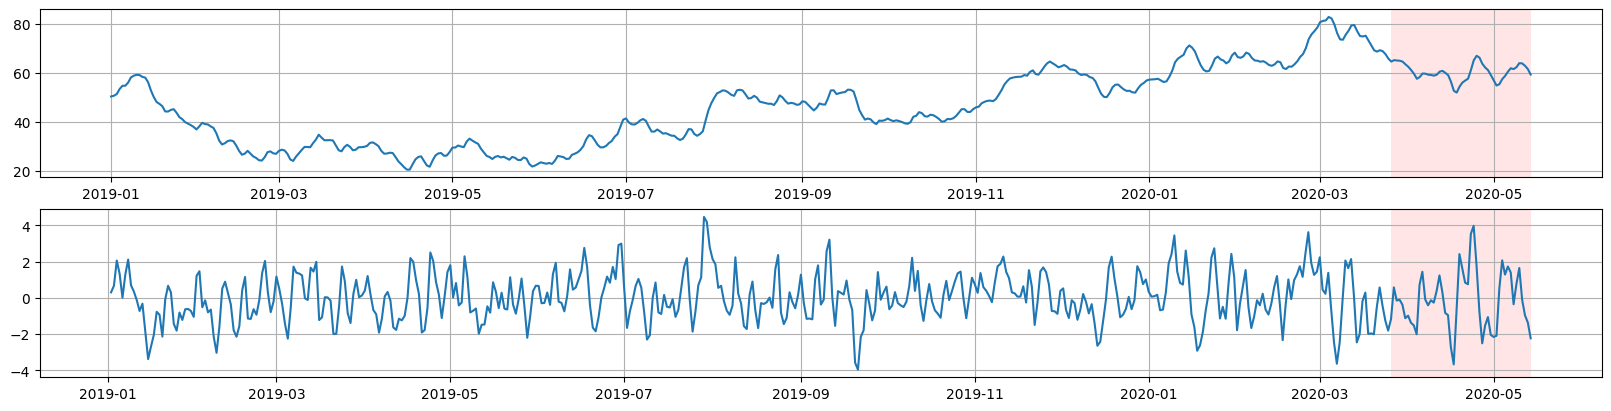

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,4),  layout='constrained')
ax1.plot(df_data )
ax1.grid()
ax1.axvspan('2020-03-26', '2020-05-14', facecolor='red', alpha=0.1)
ax2.plot(df_diff)
ax2.grid()
ax2.axvspan('2020-03-26', '2020-05-14', facecolor='red', alpha=0.1)
plt.show()

In [79]:
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]
print(train.size, test.size)

449 50


In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [100]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head(10)

,0,pred_mean,pred_last_value,pred_MA
2020-03-26,-1.170131,0.034319,-1.803658,-1.078833
2020-03-27,0.580967,0.034319,-1.803658,-0.273309
2020-03-28,-0.144902,0.032861,0.580967,0.781223
2020-03-29,-0.096564,0.032861,0.580967,0.234969
2020-03-30,-0.372334,0.032183,-0.096564,0.168994
2020-03-31,-1.118891,0.032183,-0.096564,0.115810
2020-04-01,-0.979693,0.028764,-1.118891,-0.795666
2020-04-02,-1.369431,0.028764,-1.118891,-0.191286
2020-04-03,-1.517477,0.023498,-1.369431,-0.922824
2020-04-04,-2.006735,0.023498,-1.369431,-0.254060


<Axes: >

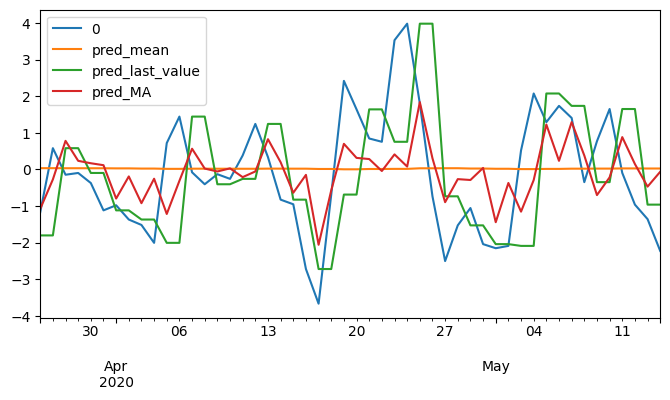

In [159]:
pred_df.plot(figsize=(8,4),  layout='constrained')

In [114]:
import torch
from torch import nn
mse = nn.MSELoss()
loss = {}

In [115]:
loss['mean'] =  mse( torch.FloatTensor( pred_df['pred_mean'][:].values),  torch.FloatTensor(pred_df[0][:].values) ).item()
loss['last_value'] = mse( torch.FloatTensor( pred_df['pred_last_value'][:].values),  torch.FloatTensor(pred_df[0][:].values) ).item()
loss['MA'] =  mse( torch.FloatTensor( pred_df['pred_MA'][:].values),  torch.FloatTensor(pred_df[0][:].values) ).item()
loss

{'mean': 2.5606298446655273,
 'last_value': 3.2494258880615234,
 'MA': 1.9481714963912964}

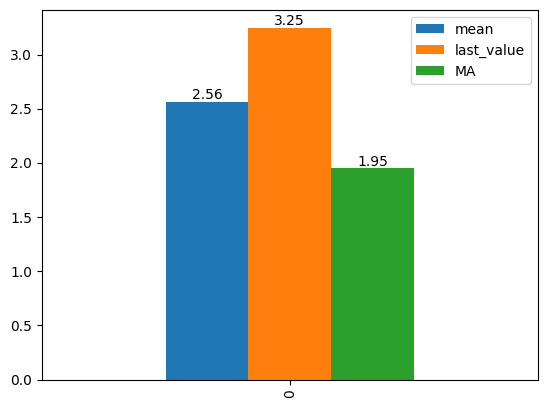

In [116]:
ax =  pd.DataFrame([loss]).plot.bar()
for index, label in enumerate(loss):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [ ]:
df_data['pred_widget_sales'] = pd.Series()
df_data['pred_widget_sales'][450:] = df_data['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

In [153]:
df_data.tail(5)

,widget_sales,pred_widget_sales
2020-05-10,64.087371,60.335201
2020-05-11,63.992081,61.218392
2020-05-12,63.029894,61.365771
2020-05-13,61.671797,60.895973
2020-05-14,59.443839,60.832373


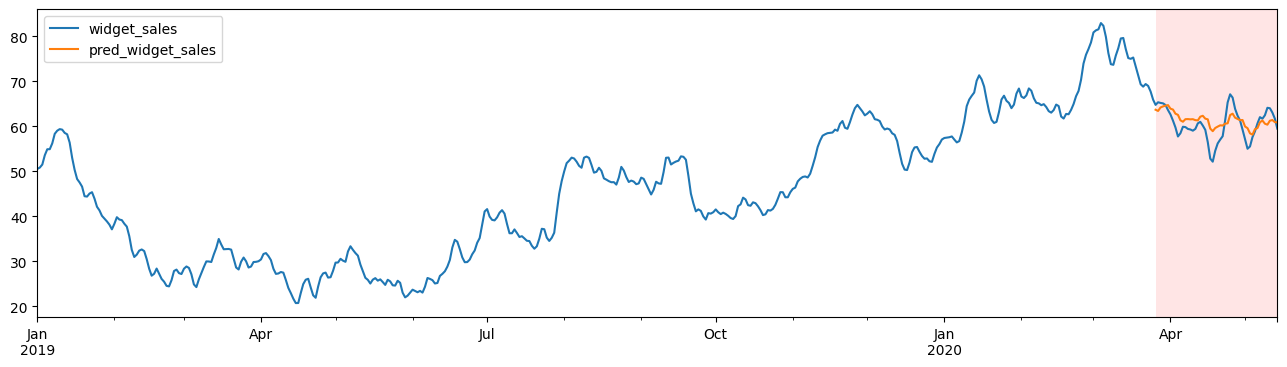

In [154]:
ax = df_data[:].plot(figsize=(16,4),  layout='constrained')
ax.axvspan('2020-03-26', '2020-05-14', facecolor='red', alpha=0.1)

In [152]:
mae = nn.L1Loss()
loss = mae(
    torch.FloatTensor( df_data['pred_widget_sales']['2020-03-26':].values),  
    torch.FloatTensor(df_data['widget_sales']['2020-03-26':].values) 
).item()
loss

2.3244712352752686